## <center>Inicio

In [2]:
# Importación de librerías

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import random

In [3]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [5]:
from sklearn.utils import shuffle

In [6]:
import xgboost as xgb

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization

In [ ]:
# Importación de los documentos

tw_train = pd.read_csv('./train.csv')
tw_test = pd.read_csv('./test.csv')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

## <center>Preprocesamiento y Feature Extraction a partir de 'text'

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

regexes = {'hashtags':r'(#)+', 'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'}

referenceDF = pd.read_csv('./headlines_reference_values.csv').drop(columns = 'Unnamed: 0')
ref = referenceDF.loc[0]

basicStopwords = stopwords.words('english')
myStopwords = set(basicStopwords + list(punctuation))

In [7]:
def isInText(DF, feature):
    DF[feature[0]+'_in_t'] = 0   # Inicialización de la nueva columna
    for i in range(len(DF)):
        try:
            if (DF.loc[i, feature]).lower() in (DF.loc[i, 'text']).lower(): DF.loc[i, feature[0]+'_in_t'] = 1
        except:
            continue
        
def replace_contractions(text, mapping):
    noContText = []
    counter = 0
    for t in text.split(" "):
        if t.lower() in mapping:
            noContText.append(mapping[t.lower()])
            counter += 1
        else:
            noContText.append(t) 
    return [' '.join(noContText), counter]

def Qy(regex, text):   
    try:
        return len(re.compile(regex).findall(text))
    except:
        return 0

def newFeatures(DF, regexDict):
    for k, v in regexDict.items():
        DF[['text', k]] = pd.DataFrame(DF['text'].map(lambda x: [re.compile(v).sub(r' ', x), Qy(v, x)]).tolist())

def wilsonScore(num, den):
    if num == 0:
        return round(0, 2)
    phat = num/den
    z = 1.96
    return round(((phat + z*z/(2*den) - z * np.sqrt((phat*(1-phat)+z*z/(4*den))/den))/(1+z*z/den)), 2)

def tagging(text):
    tagsCount = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, '.':0, 'X':0}
    tags = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tags += nltk.pos_tag(word_tokenize(sentence), tagset = 'universal')
    for word, tag in tags:
        tagsCount[tag] += 1    
    POS_ratio = [round((12 - list(tagsCount.values()).count(0))/12, 2)]
#     mostCommonPOS_ratio = [round(list(tagsCount.values()).count(max(tagsCount.values()))/(12-list(tagsCount.values()).count(0)), 2)]
    mostCommonPOS_ratio = [wilsonScore(list(tagsCount.values()).count(max(tagsCount.values())), 12-list(tagsCount.values()).count(0))]
    noun_ratio =  [wilsonScore(tagsCount['NOUN'], sum(tagsCount.values()))]
    return list(tagsCount.values()) + POS_ratio + mostCommonPOS_ratio + noun_ratio

def headlinesDistance(DF, ref):
    DF['dist'] = 0
    for i in range(len(DF)):
        x = DF.loc[i, ['textLenght','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT', 'polarity', 'subjectivity']]
        DF.loc[i, 'dist'] =  np.dot(x, ref)/(np.linalg.norm(x)*np.linalg.norm(ref))

def sentimentAnalysis(text):
    blob = TextBlob(text)
    return blob.sentiment

def stemmizer(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([PorterStemmer().stem(word) for word in words if word not in stopwords])

def SWRemoval(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stopwords])
    
def preprocessing(DF, contraction_mapping, regexes, ref, myStopwords):
#     originalTextLength = tw_train['text'].map(lambda x: len(x))
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, regexes) 
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
#     DF['textTrash'] = originalTextLength - DF['textLenght']
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
#     DF['text'] = DF['text'].map(lambda x: stemmizer(x, myStopwords))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']    

In [10]:
# Preprocesamiento y feature extraction del text

preprocessing(tw_train, contraction_mapping, regexes, ref, myStopwords)
preprocessing(tw_test, contraction_mapping, regexes, ref, myStopwords)

## <center>Vocabulario - Embeddings

In [11]:
# Vocabulary
# las Stopwords ya quedaron afuera en el paso anterior

textList = tw_train['text'].tolist()
text = ' '.join(textList)
tokens = word_tokenize(text)
tokensFreq = nltk.FreqDist(tokens)
tokensFreq = {k:v for k,v in tokensFreq.items() if (v>5) & (v<150)}
myVocabulary = list(tokensFreq.keys())
print('El vocabulario consta de {} palabras'.format(len(myVocabulary)))

El vocabulario consta de 2173 palabras


In [27]:
# Embeddings

embeddingsFilePath = './glove.twitter.27B.100d.txt'
embeddingsFile = open(embeddingsFilePath)
embeddingsIndex = {}
for line in embeddingsFile:
    lineList = line.split()
    word = lineList[0]
    vector = np.array(lineList[1:])
    embeddingsIndex[word] = vector
embeddingsFile.close()

In [13]:
def embeddingsInVoc(voc):
    noEmbeddingTokens = []
    for token in voc:
        if token.lower() not in embeddingsIndex:
            noEmbeddingTokens.append(token)
    print('{}% de los tokens tienen embedding'.format( 100 - round((len(noEmbeddingTokens)/len(voc))*100, 2) ))
    return noEmbeddingTokens

noEmbeddingTokens = embeddingsInVoc(myVocabulary)

96.82% de los tokens tienen embedding


In [14]:
tokensReplacement = {'icemoon':'ice moon','bioterror':'bio terror','bioterrorism':'bio terrorism','microlight':'micro light',
                     'w/heavenly':'heavenly','typhoon-devastated':'typhoon devastated',"'save":'save','animalrescue':'animal rescue',
                     'mediterran':'mediterranean','meat-loving':'meat loving',"'suicide":'suicide'}
tokensDeletion = set(tokensReplacement.keys()) ^ set(noEmbeddingTokens)

In [15]:
# Últimos detalles sobre la limpieza del texto
def replace_noEmbeddingTokens(text, replacement_mapping, deletion_list):
    newText = []
    for word in word_tokenize(text):
        if word.lower() in replacement_mapping:
            newText.append(replacement_mapping[word.lower()])
        elif word.lower() not in deletion_list:
            newText.append(word) 
    return ' '.join(newText)

tw_train['text'] = tw_train['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))
tw_test['text'] = tw_test['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [16]:
# Redefino vocabulario
myVocabulary = [w for w in myVocabulary if w not in tokensDeletion]
myVocabulary = [tokensReplacement[w] if (w in tokensReplacement) else w for w in myVocabulary]
myVocabulary = list(set(myVocabulary))
print('El nuevo vocabulario consta de {} palabras'.format(len(myVocabulary)))

El nuevo vocabulario consta de 2112 palabras


In [17]:
noEmbeddingTokens = embeddingsInVoc(myVocabulary)

99.67% de los tokens tienen embedding


### Resultados

In [18]:
tw_train.to_csv('tw_train.csv', index = False)
tw_test.to_csv('tw_test.csv', index = False)

with open('myVocabulary.pickle', 'wb') as f:
    pickle.dump(myVocabulary, f)

### Carga de los resultados

In [8]:
with open('myVocabulary.pickle', 'rb') as f:
    myVocabulary = pickle.load(f)

### Más de embeddings

In [9]:
# Creación de un Vocabulary Index
# El índice cero y el índice 1 se reservan para padding y "out of index", respectivamente.

vocabularyIndex = {}
for i in range(2, len(myVocabulary)+2):  # myVocabulary es una lista ya creada anteriormente
    vocabularyIndex[myVocabulary[i-2]] = i
    
# Construcción de la embedding matrix

num_tokens = len(vocabularyIndex) + 2
embeddings_dim = 100
embeddingsMatrix = np.zeros((num_tokens, embeddings_dim))
for word, i in vocabularyIndex.items():
    embedding_vector = embeddingsIndex.get(word)
    if embedding_vector is not None:
        embeddingsMatrix[i] = embedding_vector
    else:
        continue
print('La embeddingsMatrix resultante tiene las dimensiones {}'.format(embeddingsMatrix.shape))

# Construcción de los vectores de entrada

def vocMapping(text):
    vector = []
    for word in word_tokenize(text):
        try:
            vector.append(vocabularyIndex[word])
        except:
            vector.append(1)  # Embeddings desconocidos
    vector = vector + [0]*(num_tokens - len(vector))  # Padding
    return np.array(vector).astype(np.float)

La embeddingsMatrix resultante tiene las dimensiones (2114, 100)


## <center>Data Augmentation: Creación de un nuevo set de train basado en ruido

In [20]:
# Data a utilizar: embeddingsIndex, que es el diccionario tal que (k, v) = (word, embedding)
# Lo reduzco a una forma que contenga solo las claves que también se encuentran en myVocabulary

myEmbeddingsIndex = {k:v.astype(np.float) for k,v in embeddingsIndex.items() if k in myVocabulary}

In [21]:
def text_mutation(text, embDict):
    words = text.split()
    for i in range(len(words)):
        if words[i].lower() in embDict:
            minDistance = -1
            newWord = words[i]
            for k, v in embDict.items():
                if k != words[i].lower():
                    distance = np.dot(embDict[words[i].lower()], v)/(np.linalg.norm(embDict[words[i].lower()])*np.linalg.norm(v))
                    if (1 - distance) < (1 - minDistance):
                        minDistance = distance
                        newWord = k
            words[i] = newWord
    words.insert(random.randint(0, len(words)-1) ,list(embDict.keys())[random.randint(0, len(embDict)-1)])
    return ' '.join(words)

In [22]:
def noisy_preprocessing(DF, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex):
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    newFeatures(DF, {'hashtags':r'(#)+'})
    DF['text'] = DF['text'].map(lambda x: text_mutation(x, myEmbeddingsIndex))
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, {'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'})
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']
    DF['text'] = DF['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [23]:
tw_train_noise = pd.read_csv('./train.csv')

In [24]:
noisy_preprocessing(tw_train_noise, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex)

In [36]:
print(f'''Para ilustrar la diferencia:
Original: {tw_train.loc[150,'text']}
Mutado: {tw_train_noise.loc[150,'text']}''')

Para ilustrar la diferencia:
Original: might killed airplane accident night car wreck politics best
Mutado: could murdered plane crash tonight truck wreck politics inch best


In [42]:
print(f'''Para ilustrar la diferencia:
Original: {tw_train.loc[0,'text']}
Mutado: {tw_train_noise.loc[0,'text']}''')

Para ilustrar la diferencia:
Original: deeds reason earthquake may allah forgive us
Mutado: deeds wrong officers tornado close islam forgive bring


In [26]:
tw_train_noise = tw_train_noise[list(tw_train.columns)]

### Resultados:

### Uso: Para balancear el Train Set original

In [9]:
def balance(clean, noise):
    delta = clean['target'].value_counts().loc[0] - clean['target'].value_counts().loc[1]
    if delta > 0:
        add_balance = noise.loc[noise['target'] == 1, :].sample(n = abs(delta), replace = False, random_state = 60)
    elif delta < 0:
        add_balance = noise.loc[noise['target'] == 0, :].sample(n = abs(delta), replace = False, random_state = 60)
    balanced = pd.concat([clean, add_balance], axis=0, join = 'outer', ignore_index = True)    
    return shuffle(balanced)

### Uso: Para agragar ruido

In [10]:
def add_noise(clean, noise, noise_level,keep_proportion = True, return_residual_noise = False):
    
    if keep_proportion == True:
        stratify = noise['target']
    else:
        stratify = None
        
    residual_noise, noise_required = train_test_split(noise, stratify = stratify, test_size = noise_level)
    noisyDF = pd.concat([clean, noise_required], axis=0, join = 'outer', ignore_index = True)
    
    if return_residual_noise == False:
        return shuffle(noisyDF)
    else:
        return shuffle(noisyDF), shuffle(residual_noise)

## <center>Deep learning

## Deep Learning: MLP y Holdout Set Validation

In [ ]:
# SET DE DATOS OPCIÓN 1: USANDO EL TRAIN SET Y NADA MAS
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train, tw_test, 0.2, 123)

In [ ]:
# SET DE DATOS: OPCION 2: AGREGANDO RUIDO AL TRAIN SET PARA BALANCEAR
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_balanced = balance(tw_train, tw_train_noise)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_balanced, tw_test, 0.2, 22)

In [ ]:
# SET DE DATOS OPCIÓN 3: AGREGANDO RUIDO AL TRAIN SET MANTENIENDO DESBALANCE
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noisy = add_noise(tw_train, tw_train_noise, 0.6, keep_proportion = True, return_residual_noise = False)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_noisy, tw_test, 0.2, 111)

In [ ]:
# SET DE DATOS OPCIÓN 4: USAR TODO EL TRAIN PARA ENTRENAR Y RUIDO PARA VALIDAR
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
_, _, X_val_text, X_val_nf, _, _, _, y_val = load_data_holdout(tw_train_noise, tw_test, 0.4, 123)
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
X_train_text, X_train_nf, X_test_text, X_test_nf, y_train = load_data_cv(tw_train, tw_test)

In [232]:
# SET DE DATOS: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [233]:
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_noisy_balanced, tw_test, 0.20)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (10420, 24)
        Set de entrenamiento, texto: (10420, 2114)
        Set de validación, features numéricos: (2606, 24)
        Set de validación, texto: (2606, 2114)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 2114)


In [254]:
# Creación del modelo

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
outputs1 = layers.GlobalAveragePooling1D()(x1)
# x = layers.GlobalAveragePooling1D()(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs2, outputs1])  # Combinación de las salidas de ambas ramas
x = layers.BatchNormalization(axis=-1, trainable=False)(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dense(256, activation="relu")(x)  # Antes 128
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dropout(0.5)(x)  # Antes no estaba
x = layers.Dense(32, activation="relu")(x)  # Antes 64
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

mlp_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'mlp_model')

In [255]:
# Compilación del modelo

optimizer = keras.optimizers.Adam(learning_rate = 0.005)
mlp_model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [256]:
mlp_model_history = mlp_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val), 
                    batch_size = 32, epochs = 25, verbose = 2)

Epoch 1/25
326/326 - 8s - loss: 0.6573 - accuracy: 0.6252 - val_loss: 0.6170 - val_accuracy: 0.6769
Epoch 2/25
326/326 - 8s - loss: 0.6274 - accuracy: 0.6585 - val_loss: 0.5917 - val_accuracy: 0.6880
Epoch 3/25
326/326 - 8s - loss: 0.6266 - accuracy: 0.6674 - val_loss: 0.5990 - val_accuracy: 0.6865
Epoch 4/25
326/326 - 8s - loss: 0.6196 - accuracy: 0.6674 - val_loss: 0.5884 - val_accuracy: 0.6957
Epoch 5/25
326/326 - 8s - loss: 0.6144 - accuracy: 0.6726 - val_loss: 0.5765 - val_accuracy: 0.7053
Epoch 6/25
326/326 - 8s - loss: 0.6074 - accuracy: 0.6720 - val_loss: 0.5673 - val_accuracy: 0.7068
Epoch 7/25
326/326 - 8s - loss: 0.6044 - accuracy: 0.6802 - val_loss: 0.5691 - val_accuracy: 0.6980
Epoch 8/25
326/326 - 8s - loss: 0.5893 - accuracy: 0.6884 - val_loss: 0.5552 - val_accuracy: 0.7164
Epoch 9/25
326/326 - 8s - loss: 0.5849 - accuracy: 0.6925 - val_loss: 0.5442 - val_accuracy: 0.7310
Epoch 10/25
326/326 - 7s - loss: 0.5740 - accuracy: 0.7085 - val_loss: 0.5367 - val_accuracy: 0.7295

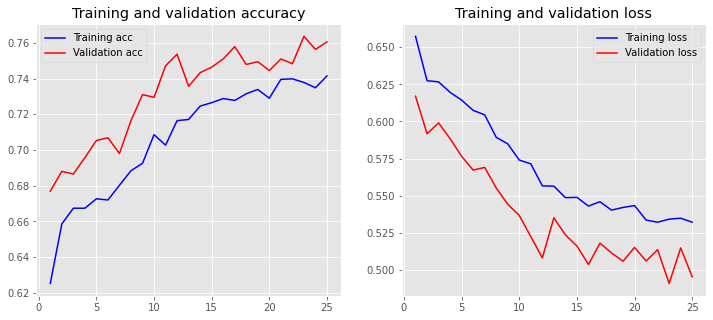

In [257]:
plot_history(mlp_model_history)

In [258]:
# Predicciones
mlp_model_prediction = toCategory(mlp_model.predict([X_test_text, X_test_nf]))

In [259]:
# Más evaluación
print('ERROR DE SUBMIT:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], mlp_model_prediction)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], mlp_model_prediction)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], mlp_model_prediction)))

ERROR DE SUBMIT:

El F1-Score es: 0.7067437379576108 

La confusion matrix es: 
[[1585  276]
 [ 485  917]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1861
           1       0.77      0.65      0.71      1402

    accuracy                           0.77      3263
   macro avg       0.77      0.75      0.76      3263
weighted avg       0.77      0.77      0.76      3263
 



## Conv1D - Holdout Validation

In [12]:
# SET DE DATOS: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [18]:
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_noisy_balanced, tw_test, 0.20)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (10420, 24)
        Set de entrenamiento, texto: (10420, 2114)
        Set de validación, features numéricos: (2606, 24)
        Set de validación, texto: (2606, 2114)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 2114)


In [44]:
# Creación del modelo

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
# x1 = layers.Conv1D(100, 5, padding="same", activation = "relu")(x1)
# x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
x1 = layers.Conv1D(100, 7, padding="same", activation = "relu")(x1)
outputs11 = layers.GlobalAveragePooling1D()(x1)
# outputs12 = layers.GlobalMaxPooling1D()(x1)
# x = layers.GlobalAveragePooling1D()(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas
x = layers.BatchNormalization(axis=-1, trainable=False)(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dense(256, activation="relu")(x)  # Antes 128
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dropout(0.5)(x)  # Antes no estaba
x = layers.Dense(32, activation="relu")(x)  # Antes 64
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

conv1d_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'conv1d_model')

# este andaba por los 0.78

NameError: name 'outputs1' is not defined

In [46]:
conv1d_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.004), metrics=["accuracy"])
# El learning rate estaba en 0.003

In [47]:
conv1d_model_history = conv1d_model.fit([X_train_text, X_train_nf], y_train, 
                                         validation_data = ([X_val_text, X_val_nf], y_val), 
                                         batch_size = 32, epochs = 5, verbose = 2)

Epoch 1/5
326/326 - 219s - loss: 0.5321 - accuracy: 0.7400 - val_loss: 0.4933 - val_accuracy: 0.7671
Epoch 2/5
326/326 - 224s - loss: 0.4935 - accuracy: 0.7726 - val_loss: 0.4774 - val_accuracy: 0.7701
Epoch 3/5
326/326 - 224s - loss: 0.4742 - accuracy: 0.7816 - val_loss: 0.4759 - val_accuracy: 0.7694
Epoch 4/5
326/326 - 225s - loss: 0.4630 - accuracy: 0.7856 - val_loss: 0.4689 - val_accuracy: 0.7767
Epoch 5/5
326/326 - 225s - loss: 0.4506 - accuracy: 0.7988 - val_loss: 0.4760 - val_accuracy: 0.7751


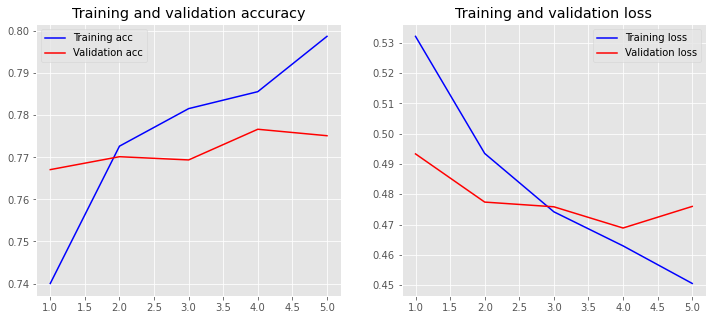

In [48]:
plot_history(conv1d_model_history)

In [270]:
conv1d_model_prediction = toCategory(conv1d_model.predict([X_test_text, X_test_nf]))

In [271]:
print('ERROR DE SUBMIT:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], conv1d_model_prediction)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], conv1d_model_prediction)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], conv1d_model_prediction)))

ERROR DE SUBMIT:

El F1-Score es: 0.737593984962406 

La confusion matrix es: 
[[1584  277]
 [ 421  981]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1861
           1       0.78      0.70      0.74      1402

    accuracy                           0.79      3263
   macro avg       0.78      0.78      0.78      3263
weighted avg       0.79      0.79      0.78      3263
 



## Deep Learning: Conv1D + LSTM y Holdout Set Validation

In [195]:
# MISMO SET DE DATOS QUE EN EL MODELO ANTERIOR

In [54]:
# Creación del modelo

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Conv1D(100, 3, padding="same", activation="relu")(x1)
x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
x1 = layers.LSTM(50, activation='relu', return_sequences = True)(x1)  # Antes 90
outputs1 = layers.GlobalAveragePooling1D()(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas

x = layers.BatchNormalization(trainable = False)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

conv_lstm_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'conv_lstm_model')

In [55]:
conv_lstm_model.summary()

Model: "conv_lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 2114)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 2114, 100)    211400      input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 2114, 100)    400         embedding_7[0][0]                
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 2114, 100)    0           batch_normalization_25[0][0]     
____________________________________________________________________________________

In [56]:
# Compilación del modelo

# optimizer = keras.optimizers.Adam(learning_rate = 0.002)
conv_lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [57]:
conv_lstm_model_history = conv_lstm_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val), 
                    batch_size = 32, epochs = 5, verbose = 2)

Epoch 1/5
326/326 - 153s - loss: nan - accuracy: 0.5038 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/5
326/326 - 155s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/5


KeyboardInterrupt: 

In [ ]:
plot_history(conv_lstm_model_history)

In [ ]:
conv_lstm_model_prediction = conv_lstm_model.predict([X_test_text, X_test_nf])

In [ ]:
def toCategory(arr):
    return [1 if arr[i][0]>=0.5 else 0 for i in range(len(arr))]

In [ ]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], toCategory(conv_lstm_model_prediction))))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], toCategory(conv_lstm_model_prediction))))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], toCategory(conv_lstm_model_prediction))))

## Bi-LSTM y Holdout Set Validation

In [195]:
# MISMO SET DE DATOS QUE EN EL MODELO ANTERIOR

In [272]:
# Creación del modelo

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs1 = layers.Bidirectional(layers.LSTM(64))(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs1, outputs2])

x = layers.BatchNormalization(trainable = False)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

bilstm_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'bilstm_model')

In [273]:
bilstm_model.summary()

Model: "bilstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 2114)]       0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 2114, 100)    211400      input_48[0][0]                   
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 2114, 100)    400         embedding_24[0][0]               
__________________________________________________________________________________________________
dropout_58 (Dropout)            (None, 2114, 100)    0           batch_normalization_108[0][0]    
_______________________________________________________________________________________

In [274]:
# Compilación del modelo

optimizer = keras.optimizers.Adam(learning_rate = 0.003)
bilstm_model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [275]:
bilstm_model_history = bilstm_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val), 
                    batch_size = 32, epochs = 6, verbose = 2)

Epoch 1/6
326/326 - 638s - loss: 0.5273 - accuracy: 0.7399 - val_loss: 0.4691 - val_accuracy: 0.7748
Epoch 2/6
326/326 - 611s - loss: 0.4885 - accuracy: 0.7679 - val_loss: 0.4524 - val_accuracy: 0.7897
Epoch 3/6
326/326 - 651s - loss: 0.4800 - accuracy: 0.7722 - val_loss: 0.4537 - val_accuracy: 0.7843
Epoch 4/6
326/326 - 561s - loss: 0.4689 - accuracy: 0.7765 - val_loss: 0.4479 - val_accuracy: 0.7939
Epoch 5/6
326/326 - 586s - loss: 0.4744 - accuracy: 0.7758 - val_loss: 0.4441 - val_accuracy: 0.7886
Epoch 6/6
326/326 - 582s - loss: 0.4560 - accuracy: 0.7877 - val_loss: 0.4411 - val_accuracy: 0.7901


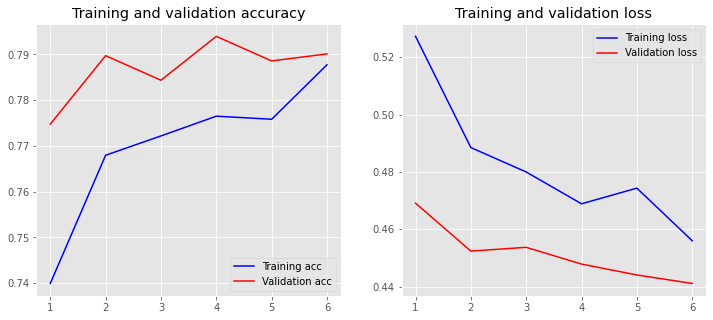

In [276]:
plot_history(bilstm_model_history)

In [277]:
bilstm_model_prediction = bilstm_model.predict([X_test_text, X_test_nf])

In [14]:
def toCategory(arr):
    return [1 if arr[i][0]>=0.5 else 0 for i in range(len(arr))]

In [278]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], toCategory(bilstm_model_prediction))))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], toCategory(bilstm_model_prediction))))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], toCategory(bilstm_model_prediction))))

ERROR DE VALIDACIÓN:

El F1-Score es: 0.7453551912568306 

La confusion matrix es: 
[[1541  320]
 [ 379 1023]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1861
           1       0.76      0.73      0.75      1402

    accuracy                           0.79      3263
   macro avg       0.78      0.78      0.78      3263
weighted avg       0.79      0.79      0.79      3263
 



## Bi-LSTM y Conv1D - Holdout Set Validation

In [195]:
# MISMO SET DE DATOS QUE EN EL MODELO ANTERIOR

In [279]:
# Creación del modelo

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Conv1D(100, 3, padding="same", activation="relu")(x1)
x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
outputs1 = layers.Bidirectional(layers.LSTM(64))(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs1, outputs2])

x = layers.BatchNormalization(trainable = False)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

conv1d_bilstm_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'conv1d_bilstm_model')

In [280]:
conv1d_bilstm_model.summary()

Model: "conv1d_bilstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 2114)]       0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 2114, 100)    211400      input_50[0][0]                   
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 2114, 100)    400         embedding_25[0][0]               
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 2114, 100)    0           batch_normalization_111[0][0]    
________________________________________________________________________________

In [281]:
# Compilación del modelo

optimizer = keras.optimizers.Adam(learning_rate = 0.002)
conv1d_bilstm_model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [282]:
conv1d_bilstm_model_history = conv1d_bilstm_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val), 
                    batch_size = 32, epochs = 6, verbose = 2)

Epoch 1/6
326/326 - 224s - loss: 0.5325 - accuracy: 0.7356 - val_loss: 0.4676 - val_accuracy: 0.7794
Epoch 2/6
326/326 - 227s - loss: 0.4966 - accuracy: 0.7631 - val_loss: 0.4751 - val_accuracy: 0.7843
Epoch 3/6
326/326 - 228s - loss: 0.4787 - accuracy: 0.7762 - val_loss: 0.4582 - val_accuracy: 0.7916
Epoch 4/6
326/326 - 233s - loss: 0.4703 - accuracy: 0.7783 - val_loss: 0.4467 - val_accuracy: 0.7932
Epoch 5/6
326/326 - 234s - loss: 0.4660 - accuracy: 0.7806 - val_loss: 0.4434 - val_accuracy: 0.7955
Epoch 6/6
326/326 - 227s - loss: 0.4545 - accuracy: 0.7865 - val_loss: 0.4436 - val_accuracy: 0.7943


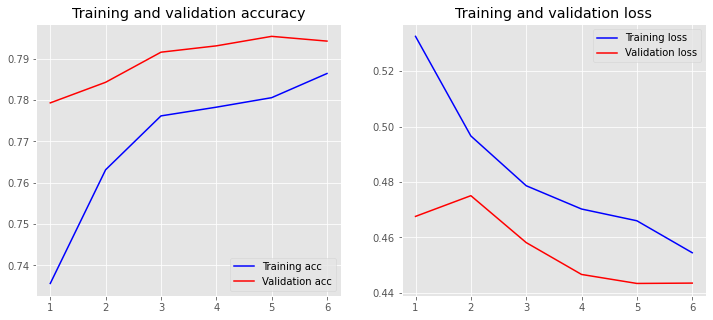

In [283]:
plot_history(conv1d_bilstm_model_history)

In [284]:
conv1d_bilstm_model_prediction = conv1d_bilstm_model.predict([X_test_text, X_test_nf])

In [ ]:
def toCategory(arr):
    return [1 if arr[i][0]>=0.5 else 0 for i in range(len(arr))]

In [285]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], toCategory(conv1d_bilstm_model_prediction))))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], toCategory(conv1d_bilstm_model_prediction))))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], toCategory(conv1d_bilstm_model_prediction))))

ERROR DE VALIDACIÓN:

El F1-Score es: 0.7484618168657258 

La confusion matrix es: 
[[1534  327]
 [ 368 1034]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1861
           1       0.76      0.74      0.75      1402

    accuracy                           0.79      3263
   macro avg       0.78      0.78      0.78      3263
weighted avg       0.79      0.79      0.79      3263
 



## Conv1D y Cross - Validation

In [ ]:
##################################  CROSS-VALIDATION  ##################################

# Parámetros
n_folds = 5
batch_size = 32
no_epochs = 5

In [15]:
def load_data_cv(TrainDF, TestDF, encode_keyword = False):
    # Numeric Features: Encoding de 'keyword' + Resultado de feature engineering
    print('Preparando las Numeric Features...')
    TrainDF_subset = TrainDF.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
    TestDF_subset = TestDF.drop(columns = ['id', 'keyword', 'location', 'text'])
    if encode_keyword == True:
        ohe = OneHotEncoder(handle_unknown = 'ignore')
        ohe.fit(np.array(TrainDF.loc[TrainDF['keyword'].isna() == False, 'keyword']).reshape((-1,1)))
        TrainDF['keyword'].fillna('NoKeyword', inplace = True)
        TrainDF_keyword_enc = ohe.transform(np.array(TrainDF['keyword']).reshape((-1,1)))
        TestDF['keyword'].fillna('NoKeyword', inplace = True)
        TestDF_keyword_enc = ohe.transform(np.array(TestDF['keyword']).reshape((-1,1)))
        print('El encoding genera {} nuevos features adicionales'.format(TrainDF_keyword_enc.shape[1]))
        X_train_nf = sparse.hstack((TrainDF_keyword_enc, sparse.csr_matrix(TrainDF_subset.values))).toarray()
        X_test_nf = sparse.hstack((TestDF_keyword_enc, sparse.csr_matrix(TestDF_subset.values))).toarray()
    else:
        X_train_nf = TrainDF_subset.to_numpy()
        X_test_nf = TestDF_subset.to_numpy()
    nf_norm_layer = layers.experimental.preprocessing.Normalization()
    nf_norm_layer.adapt(X_train_nf)
    X_train_nf = nf_norm_layer(X_train_nf)
    X_test_nf = nf_norm_layer(X_test_nf) 
    
    # Text: Formateo para embedding layer
    print('Preparando el texto... \n')
    X_train_text = np.stack(TrainDF['text'].map(lambda x: vocMapping(x)))
    X_test_text = np.stack(TestDF['text'].map(lambda x: vocMapping(x)))
    
    # Target
    y_train = np.array(TrainDF['target'])
    
    print('''Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: {}
        Set de entrenamiento, texto: {}
        Set de test, features numéricos: {}
        Set de test, texto: {}'''.format(X_train_nf.shape, X_train_text.shape, X_test_nf.shape, X_test_text.shape))
    
    return X_train_text, X_train_nf, X_test_text, X_test_nf, y_train

In [ ]:
# Sets de datos
X_train_text, X_train_nf, X_test_text, X_test_nf, y_train = load_data_cv(tw_train, tw_test)

# Almacenamiento de la información de entrenamiento
acc_per_fold = []
loss_per_fold = []

# Índices para separación
skf = StratifiedKFold(n_splits=n_folds, random_state = 123, shuffle = True)

In [141]:
# Creación del modelo iterable
def get_compiled_model():
    embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

    inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
    x1 = embedding_layer(inputs1)
    x1 = layers.BatchNormalization(trainable = False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Conv1D(100, 3, padding="same", activation = "relu")(x1)
    x1 = layers.Conv1D(100, 3, padding="same", activation = "relu")(x1)
    x1 = layers.BatchNormalization(trainable = False)(x1)
    x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
    x1 = layers.Conv1D(100, 8, padding="same", activation = "relu")(x1)
    x1 = layers.BatchNormalization(trainable = False)(x1)
    outputs1 = layers.GlobalAveragePooling1D()(x1)

    inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
    outputs2 = layers.Dense(128, activation="relu")(inputs2)

    merged_outputs = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas
    merged_outputs = layers.BatchNormalization(trainable = False)(merged_outputs)
    
    x = layers.Dropout(0.5)(merged_outputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization(trainable = False)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"])
    return model

In [ ]:
# K-fold Cross Validation
fold_no = 1
for train, validation in skf.split(X_train_text, y_train):
    fold_model = get_compiled_model()
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = fold_model.fit([X_train_text[train], tf.gather(X_train_nf, train)], y_train[train], batch_size = batch_size, epochs = no_epochs)

    # Generate generalization metrics
    scores = fold_model.evaluate([X_train_text[validation], tf.gather(X_train_nf, validation)], y_train[validation])
    print(f'\nScore for fold {fold_no}: {fold_model.metrics_names[0]} of {scores[0]}; {fold_model.metrics_names[1]} of {scores[1]*100}% \n')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    
# Average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
print('\nAverage scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [16]:
## PLOTEO DE LOS RESULTADOS

plt.style.use('ggplot')  # Ploteo de Loss y Accuracy
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

In [13]:
def toCategory(arr):  # Para pasar del vector de probabilidades al de predicciones del target
    return [1 if arr[i][0]>=0.5 else 0 for i in range(len(arr))]

In [181]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], submit_best_fold_model_prediction)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], submit_best_fold_model_prediction)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], submit_best_fold_model_prediction)))

ERROR DE VALIDACIÓN:

El F1-Score es: 0.7406551059730251 

La confusion matrix es: 
[[1629  232]
 [ 441  961]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1861
           1       0.81      0.69      0.74      1402

    accuracy                           0.79      3263
   macro avg       0.80      0.78      0.78      3263
weighted avg       0.79      0.79      0.79      3263
 



### Entrenamiento para submit

In [28]:
# SET DE DATOS: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
# tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
# tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
# X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_noisy_balanced, tw_test, 0.2, 88)
tw_train_balanced = balance(tw_train, tw_train_noise)
X_train_text, X_train_nf, X_test_text, X_test_nf, y_train = load_data_cv(tw_train_balanced, tw_test)

Preparando las Numeric Features...
El encoding genera 221 nuevos features adicionales
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (8684, 248)
        Set de entrenamiento, texto: (8684, 2114)
        Set de test, features numéricos: (3263, 248)
        Set de test, texto: (3263, 2114)


In [29]:
submit_model = get_compiled_model()
submit_model_bs = 32
submit_model_ep = 5
submit_model_history = submit_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val),
                                        batch_size = submit_model_bs, epochs = submit_model_ep, verbose = 2)

Epoch 1/5
272/272 - 161s - loss: 0.5288 - accuracy: 0.7448 - val_loss: 0.4443 - val_accuracy: 0.8016
Epoch 2/5
272/272 - 165s - loss: 0.4590 - accuracy: 0.7897 - val_loss: 0.3977 - val_accuracy: 0.8170
Epoch 3/5
272/272 - 163s - loss: 0.4393 - accuracy: 0.8012 - val_loss: 0.3979 - val_accuracy: 0.8196
Epoch 4/5
272/272 - 162s - loss: 0.4317 - accuracy: 0.8035 - val_loss: 0.3934 - val_accuracy: 0.8246
Epoch 5/5
272/272 - 165s - loss: 0.4151 - accuracy: 0.8144 - val_loss: 0.4053 - val_accuracy: 0.8204


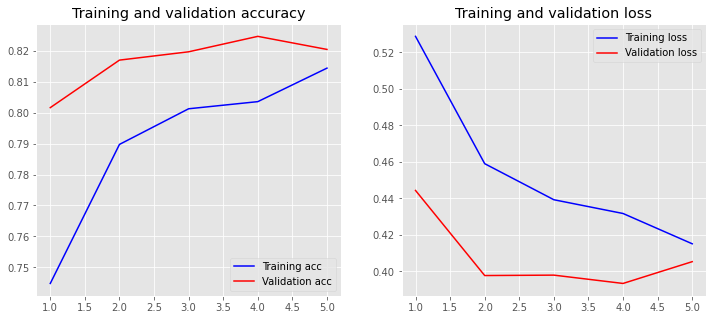

In [30]:
plot_history(submit_model_history)

In [31]:
# Predicción sobre el test set
submit_model_prediction = toCategory(submit_model.predict([X_test_text, X_test_nf]))

In [24]:
results = pd.read_csv('./results.csv')

In [32]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], submit_model_prediction)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], submit_model_prediction)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], submit_model_prediction)))

ERROR DE VALIDACIÓN:

El F1-Score es: 0.7291970802919708 

La confusion matrix es: 
[[1522  339]
 [ 403  999]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1861
           1       0.75      0.71      0.73      1402

    accuracy                           0.77      3263
   macro avg       0.77      0.77      0.77      3263
weighted avg       0.77      0.77      0.77      3263
 



In [ ]:
submission = tw_test.merge(pd.DataFrame(prediction), how = 'inner', on = tw_test.index)

In [ ]:
submission = submission[['id', 0]]

In [ ]:
submission.rename(columns = {0: 'target'}, inplace = True)

In [ ]:
submission['target'].value_counts()

In [ ]:
submission.to_csv('submission23072020.csv', index = False)

## Deep Learning: Conv1D, Holdout Validation y HP Tuning

In [117]:
# Parámetros
n_folds = 5
batch_size = 32
no_epochs = 5

In [17]:
# Separación del set de validación

def load_data_holdout(TrainDF, TestDF, validation_fraction, encode_keyword = False):
    # Numeric Features: Encoding de 'keyword' + Resultado de feature engineering
    print('Preparando las Numeric Features...')
    TrainDF_subset = TrainDF.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
    TestDF_subset = TestDF.drop(columns = ['id', 'keyword', 'location', 'text'])
    if encode_keyword == True:
        ohe = OneHotEncoder(handle_unknown = 'ignore')
        ohe.fit(np.array(TrainDF.loc[TrainDF['keyword'].isna() == False, 'keyword']).reshape((-1,1)))
        TrainDF['keyword'].fillna('NoKeyword', inplace = True)
        TrainDF_keyword_enc = ohe.transform(np.array(TrainDF['keyword']).reshape((-1,1)))
        TestDF['keyword'].fillna('NoKeyword', inplace = True)
        TestDF_keyword_enc = ohe.transform(np.array(TestDF['keyword']).reshape((-1,1)))
        print('El encoding genera {} nuevos features adicionales'.format(TrainDF_keyword_enc.shape[1])) 
        TrainDF_nf = sparse.hstack((TrainDF_keyword_enc, sparse.csr_matrix(TrainDF_subset.values))).toarray()
        X_test_nf = sparse.hstack((TestDF_keyword_enc, sparse.csr_matrix(TestDF_subset.values))).toarray()
    else:
        TrainDF_nf = TrainDF_subset.to_numpy()
        X_test_nf = TestDF_subset.to_numpy()
    X_train_nf, X_val_nf, y_train, y_val = train_test_split(TrainDF_nf, TrainDF['target'], stratify=TrainDF['target'], test_size=validation_fraction, random_state=1)
    nf_norm_layer = layers.experimental.preprocessing.Normalization()
    nf_norm_layer.adapt(X_train_nf)
    X_train_nf = nf_norm_layer(X_train_nf)
    X_val_nf = nf_norm_layer(X_val_nf)
    X_test_nf = nf_norm_layer(X_test_nf)
    
    # Formateo del texto
    print('Preparando el texto... \n')
    X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(TrainDF['text'], TrainDF['target'], stratify=TrainDF['target'], test_size=validation_fraction, random_state=1)
    X_train_text = np.stack(X_train_text.map(lambda x: vocMapping(x)))
    X_val_text = np.stack(X_val_text.map(lambda x: vocMapping(x)))
    X_test_text = np.stack(TestDF['text'].map(lambda x: vocMapping(x)))
    
    # Formateo del target
    y_train = np.array(y_train)
    y_val = np.array(y_val)

    print('''Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: {}
        Set de entrenamiento, texto: {}
        Set de validación, features numéricos: {}
        Set de validación, texto: {}
        Set de test, features numéricos: {}
        Set de test, texto: {}'''.format(X_train_nf.shape, X_train_text.shape, X_val_nf.shape, X_val_text.shape, X_test_nf.shape, X_test_text.shape))

    return X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val

In [123]:
# SET DE DATOS: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [124]:
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data_holdout(tw_train_noisy_balanced, tw_test, 0.20)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (10420, 24)
        Set de entrenamiento, texto: (10420, 2114)
        Set de validación, features numéricos: (2606, 24)
        Set de validación, texto: (2606, 2114)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 2114)


In [152]:
lalala_model = get_compiled_model()

In [154]:
lalala_model_history = lalala_model.fit([X_train_text, X_train_nf], y_train, 
                                                            validation_data = ([X_val_text, X_val_nf], y_val), 
                                                            batch_size = 32, epochs = 5, class_weight = {0:1, 1:2}, verbose = 2)

Epoch 1/5
326/326 - 189s - loss: 0.7481 - accuracy: 0.7001 - val_loss: 0.5206 - val_accuracy: 0.7322
Epoch 2/5
326/326 - 188s - loss: 0.6943 - accuracy: 0.7401 - val_loss: 0.5213 - val_accuracy: 0.7337
Epoch 3/5
326/326 - 190s - loss: 0.6772 - accuracy: 0.7441 - val_loss: 0.4934 - val_accuracy: 0.7341
Epoch 4/5
326/326 - 189s - loss: 0.6544 - accuracy: 0.7607 - val_loss: 0.5077 - val_accuracy: 0.7513
Epoch 5/5
326/326 - 188s - loss: 0.6539 - accuracy: 0.7607 - val_loss: 0.5213 - val_accuracy: 0.7375


In [155]:
lalala_model_test_prediction = toCategory(lalala_model.predict([X_test_text, X_test_nf]))

In [156]:
print('ERROR DE SUBMIT:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], lalala_model_test_prediction)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], lalala_model_test_prediction)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], lalala_model_test_prediction)))

ERROR DE SUBMIT:

El F1-Score es: 0.727764423076923 

La confusion matrix es: 
[[1146  715]
 [ 191 1211]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      1861
           1       0.63      0.86      0.73      1402

    accuracy                           0.72      3263
   macro avg       0.74      0.74      0.72      3263
weighted avg       0.76      0.72      0.72      3263
 



In [135]:
# Creación del modelo iterable para tuning

def get_tuning_model(hp):
    embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

    inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
    x1 = embedding_layer(inputs1)
    x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Conv1D(90, 3, padding="same", activation="relu")(x1)
    x1 = layers.Conv1D(90, 4, padding="same", activation="relu")(x1)
    x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
    x1 = layers.Conv1D(90, 7, padding="same", activation="relu")(x1)
    outputs1 = layers.GlobalAveragePooling1D()(x1)

    inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
    outputs2 = inputs2

    x = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas
    
    for i in range(hp.Int('layers', 2, 3)):
        x = layers.BatchNormalization(axis=-1, trainable=False)(x)
        if i == 0:
            x = layers.Dropout(0.5)(x)
        x = layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=256, step=32), activation="relu")(x)
    x = layers.BatchNormalization(axis=-1, trainable=False)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate = 0.002)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [139]:
# Creación del modelo iterable para tuning

embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
x1 = embedding_layer(inputs1)
x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Conv1D(90, 3, padding="same", activation="relu")(x1)
x1 = layers.Conv1D(90, 4, padding="same", activation="relu")(x1)
x1 = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x1)
x1 = layers.Conv1D(90, 7, padding="same", activation="relu")(x1)
outputs1 = layers.GlobalAveragePooling1D()(x1)

inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados
outputs2 = inputs2

x = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas

x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

lalala_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

In [140]:
lalala_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2114)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2114, 100)    211400      input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2114, 100)    400         embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2114, 100)    0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [136]:
dense_layers_conv1_tuner = BayesianOptimization(get_tuning_model, objective = "val_accuracy", max_trials = 25, num_initial_points=2, seed=999, 
                             directory='dense_layers_conv1_tuner', project_name='dense_layers_conv1_tuner')
dense_layers_conv1_tuner.search_space_summary()

In [138]:
dense_layers_conv1_tuning = dense_layers_conv1_tuner.search([X_train_text, X_train_nf], y_train, 
                                                            validation_data = ([X_val_text, X_val_nf], y_val), 
                                                            batch_size = 32, epochs = 5, verbose = 2)

Epoch 1/5


ValueError: in user code:

    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer batch_normalization_1 is incompatible with the layer: expected axis 1 of input shape to have value 338 but received input with shape [None, 114]


## Deep learning: LSTM, Holdout Validation y HP Tuning

In [ ]:
# Creación del modelo iterable para tuning

def get_lstm_tuning_model(hp):
    embedding_layer = layers.Embedding(num_tokens, embeddings_dim, embeddings_initializer=keras.initializers.Constant(embeddingsMatrix), trainable=False)

    inputs1 = keras.Input(batch_size = None, shape = (2188,))  # Entrada del texto vectorizado según myVocabulary
    x1 = embedding_layer(inputs1)
    x1 = layers.BatchNormalization(axis=-1, trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.LSTM(units=hp.Int('units_lstm_1', min_value=90, max_value=100, step=10), activation='relu', return_sequences = True)(x1)
    x1 = layers.LSTM(units=hp.Int('units_lstm_2', min_value=90, max_value=100, step=10), activation='relu')(x1)
    outputs1 = x1

    inputs2 = keras.Input(batch_size = None, shape = (248,))  # Entrada de los features numéricos completamente pre-procesados
    outputs2 = layers.Dense(128, activation="relu")(inputs2)

    merged_outputs = layers.Concatenate(axis = 1)([outputs1, outputs2])  # Combinación de las salidas de ambas ramas
    merged_outputs = layers.BatchNormalization(trainable = False)(merged_outputs)
    
    x = layers.Dropout(0.5)(merged_outputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization(axis=-1, trainable=False)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate = 0.003)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
lstm_tuner = BayesianOptimization(get_lstm_tuning_model, objective = "val_accuracy", max_trials = 20, num_initial_points=2, seed=444, 
                             directory='LSTM_opt', project_name='LSTM_opt')
lstm_tuner.search_space_summary()

In [ ]:
lstm_tuner = lstm_tuner.search([X_train_text, X_train_nf], y_train_text, validation_data = ([X_val_text, X_val_nf], y_val_text), 
                        batch_size = 32, epochs = 5, verbose = 2)